In [5]:
# Unzip Dataset
!unzip -q /kaggle/input/dogs-vs-cats/test1.zip
!unzip -q /kaggle/input/dogs-vs-cats/train.zip

In [7]:
# Requirements
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from tensorflow.keras import models, layers, optimizers

In [8]:
# Load and preprocess the image
def load_and_preprocess_image(path):
    image = cv2.imread(path)  # Example: Using OpenCV to load the image
    image = cv2.resize(image, (150, 150))  # Example: Resize the image to (150, 150)
    image = image.astype(np.float32)  # Example: Convert the image to float32
    image /= 255.0  # Example: Normalize the image by dividing by 255.0
    return image

# Add Rain Effect
def add_rain_effect(image, raindrops=random.randint(200, 300), thickness=1, length=20, angle=10):
    height, width, _ = image.shape

    for _ in range(raindrops):
        x = np.random.randint(0, width)
        y = np.random.randint(0, height)
        l = np.random.randint(1, length)
        theta = np.random.randint(80, 100)

        dx = int(l * np.cos(np.deg2rad(theta)))
        dy = int(l * np.sin(np.deg2rad(theta)))

        cv2.line(image, (x, y), (x + dx, y + dy), (200, 200, 200), thickness)

    return image

# Add Snow Effect
def add_snow_effect(image, snowflakes=random.randint(100, 150), speed=1):
    height, width, _ = image.shape
    random_size = random.randint(1,2)
    size=(random_size, random_size)
    
    snowflakes_coords = np.zeros((snowflakes, 2), dtype=np.int32)
    snowflakes_coords[:, 0] = np.random.randint(0, width, snowflakes_coords.shape[0])
    snowflakes_coords[:, 1] = np.random.randint(0, height, snowflakes_coords.shape[0])

    for (x, y) in snowflakes_coords:
        snow_color = random.randint(200, 255)  # Random color between gray and white
        cv2.ellipse(image, (x, y), size, 0, 0, 360, (snow_color, snow_color, snow_color), -1)
        y += speed
        if y > height:
            y = 0
            x = np.random.randint(0, width)
        cv2.ellipse(image, (x, y), size, 0, 0, 360, (snow_color, snow_color, snow_color), -1)

    return image


def add_blur(image_HLS, x, y, hw):
    image_copy = np.copy(image_HLS)
    image_copy[y:y+hw, x:x+hw, 1] = image_copy[y:y+hw, x:x+hw, 1] + 1
    image_copy[:, :, 1][image_copy[:, :, 1] > 255] = 255
    image_copy[y:y+hw, x:x+hw, 1] = cv2.blur(image_copy[y:y+hw, x:x+hw, 1], (10, 10))
    return image_copy


def generate_random_blur_coordinates(imshape, hw):
    haze_points = []
    midx = int(imshape[1] / 2)
    midy = int(imshape[0] / 2)    
    index = 1
    while(index < 10):
        x = np.random.randint(midx - 2 * hw, midx + 2 * hw)
        y = np.random.randint(midy - 2 * hw, midy + 2 * hw)
        if x < 0 or y < 0 or x >= imshape[1] - hw or y >= imshape[0] - hw:
            continue
        haze_points.append((x, y))
        index += 1
    return haze_points


# Add Fog Effect
def add_fog_effect(image, foginess=0.5):
    image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Generate a white image with the same size as the input image
    fog = np.ones_like(image) * 255

    # Calculate the kernel size based on the foginess level
    ksize = max(1, int(foginess * 20))
    if ksize % 2 == 0:
        ksize += 1

    # Apply Gaussian blur to the fog image based on the kernel size
    fog = cv2.GaussianBlur(fog, (ksize, ksize), 0)

    # Blend the fog image with the input image using alpha blending
    alpha = 1 - foginess
    image_with_fog = cv2.addWeighted(image, alpha, fog, foginess, 0)
    
    image_with_fog_HLS = cv2.cvtColor(image_with_fog, cv2.COLOR_RGB2HLS)
    mask = np.zeros_like(image_with_fog)

    imshape = image_with_fog.shape
    hw = 100

    image_with_fog_HLS[:, :, 1] = image_with_fog_HLS[:, :, 1] * 0.8

    haze_list = generate_random_blur_coordinates(imshape, hw)

    for haze_points in haze_list:
        image_with_fog_HLS[:, :, 1][image_with_fog_HLS[:, :, 1] > 255] = 255
        image_with_fog_HLS = add_blur(image_with_fog_HLS, haze_points[0], haze_points[1], hw)

    image_with_fog_RGB = cv2.cvtColor(image_with_fog_HLS, cv2.COLOR_HLS2RGB)
    
    return image_with_fog_RGB

In [9]:
import random
import numpy as np
from sklearn.model_selection import train_test_split

# Example data and parameters
train_directory = "/kaggle/working/train"  # Directory containing training images
batch_size = 32  # Batch size for training
num_images = 10000  # Number of original images to use

# Split train images into training and validation sets
paths = np.array([os.path.join(train_directory, file) for file in os.listdir(train_directory)])
labels = np.array([1 if file.split('.')[0] == 'dog' else 0 for file in os.listdir(train_directory)])

# Randomly select num_images
indices = random.sample(range(len(paths)), num_images)
paths = paths[indices]
labels = labels[indices]

train_paths, val_paths, train_labels, val_labels = train_test_split(paths, labels, test_size=0.2, random_state=42)

In [11]:
num_classes = len(set(labels))  # Number of classes

# Load and preprocess the training images
train_images = []
for path in train_paths:
    image = load_and_preprocess_image(path)
    train_images.append(image)

train_images = np.array(train_images)

# Load and preprocess the validation images
val_images = []
for path in val_paths:
    image = load_and_preprocess_image(path)
    val_images.append(image)

val_images = np.array(val_images)

# Augment the training images with rain or snow effects
augmented_images = []
augmented_labels = []
for ind, image in enumerate(train_images):
    img = image.copy()
    augmentation_type = np.random.choice(['rain', 'snow'])
    if augmentation_type == 'rain':
        augmented_image = add_rain_effect(img)
    else:
        augmented_image = add_snow_effect(img)

    augmented_images.append(augmented_image)
    augmented_labels.append(train_labels[ind])

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate the original images with augmented images
all_train_images = np.concatenate([train_images, augmented_images], axis=0)
all_train_labels = np.concatenate([train_labels, augmented_labels], axis=0)

# Print the shapes of train_images and train_labels
print(all_train_images.shape, all_train_labels.shape)

(16000, 150, 150, 3) (16000,)


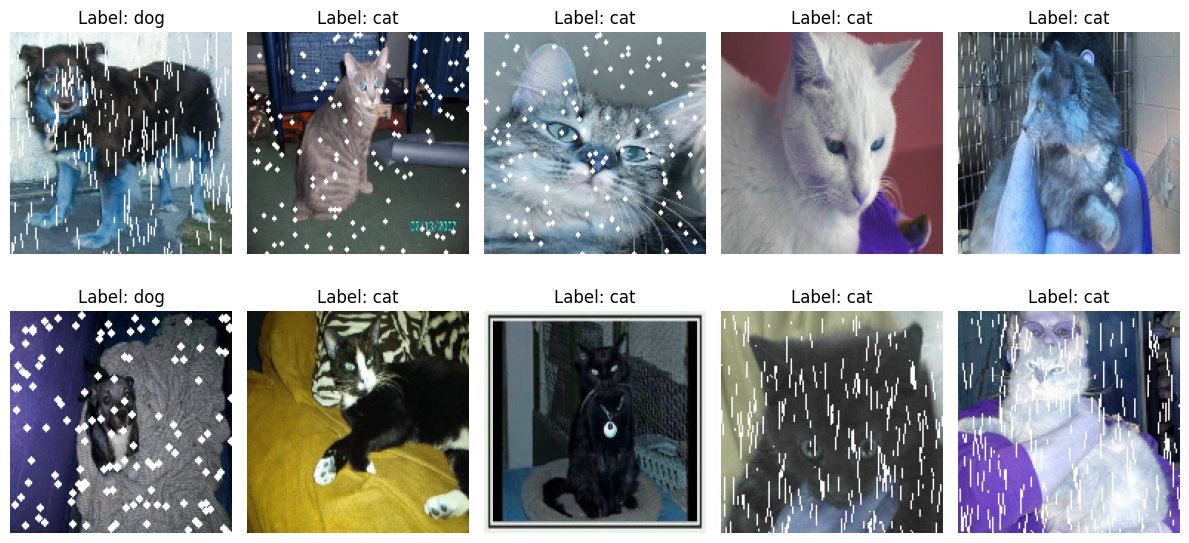

In [12]:
import random
import matplotlib.pyplot as plt

# Randomly select 10 indices from the training set
random_indices = random.sample(range(len(all_train_labels)), 10)

# Create subplots to display images
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.flatten()

# Iterate over the selected indices
for i, index in enumerate(random_indices):
    # Get the image and label
    image = all_train_images[index]
    label = all_train_labels[index]

    # If the image has 2 channels, convert it to RGB
    if image.shape[-1] == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Display the image with its label
    axs[i].imshow(image)
    if label:
        name='dog'
    else:
        name="cat"
    axs[i].set_title("Label: {}".format(name))
    axs[i].axis("off")

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
# Load the InceptionV3 model without the top (fully connected) layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

# Add a custom head on top of the base model
model = models.Sequential()

# Add the InceptionV3 base model
model.add(base_model)

# Add the custom layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the number of training steps and validation steps per epoch
train_steps = len(train_images) // batch_size
val_steps = len(val_images) // batch_size

# Train the model
history = model.fit(
    train_images,
    train_labels,
    batch_size=batch_size,
    steps_per_epoch=train_steps,
    epochs=10,
    validation_data=(val_images, val_labels),
    validation_steps=val_steps
)

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/10
250/250 [==============================] - 24s 43ms/step - loss: 0.6362 - accuracy: 0.9222 - val_loss: 0.1353 - val_accuracy: 0.9456
Epoch 2/10
250/250 [==============================] - 9s 34ms/step - loss: 0.1400 - accuracy: 0.9481 - val_loss: 0.1118 - val_accuracy: 0.9572
Epoch 3/10
250/250 [==============================] - 9s 35ms/step - loss: 0.1228 - accuracy: 0.9520 - val_loss: 0.1115 - val_accuracy: 0.9587
Epoch 4/10
250/250 [==============================] - 9s 35ms/step - loss: 0.1176 - accuracy: 0.9545 - val_loss: 0.1330 - val_accuracy: 0.9506
Epoch 5/10
250/250 [==============================] - 9s 35ms/step - loss: 0.0999 - accuracy: 0.9590 - val_loss: 0.1122 - val_accuracy: 0.9567
Epoch 6/10
250/250 [==============================] - 9s 35ms/step - loss: 0.0863 - accuracy: 0.9656 - val_loss: 0.1150 - val_accuracy: 0.9577
Epoch 7/10
250/250 [==============================] - 9s 35ms/step - loss: 0

63/63 [==============================] - 3s 47ms/step - loss: 0.1279 - accuracy: 0.9580
Validation Loss: 0.12788821756839752
Validation Accuracy: 0.9580000042915344


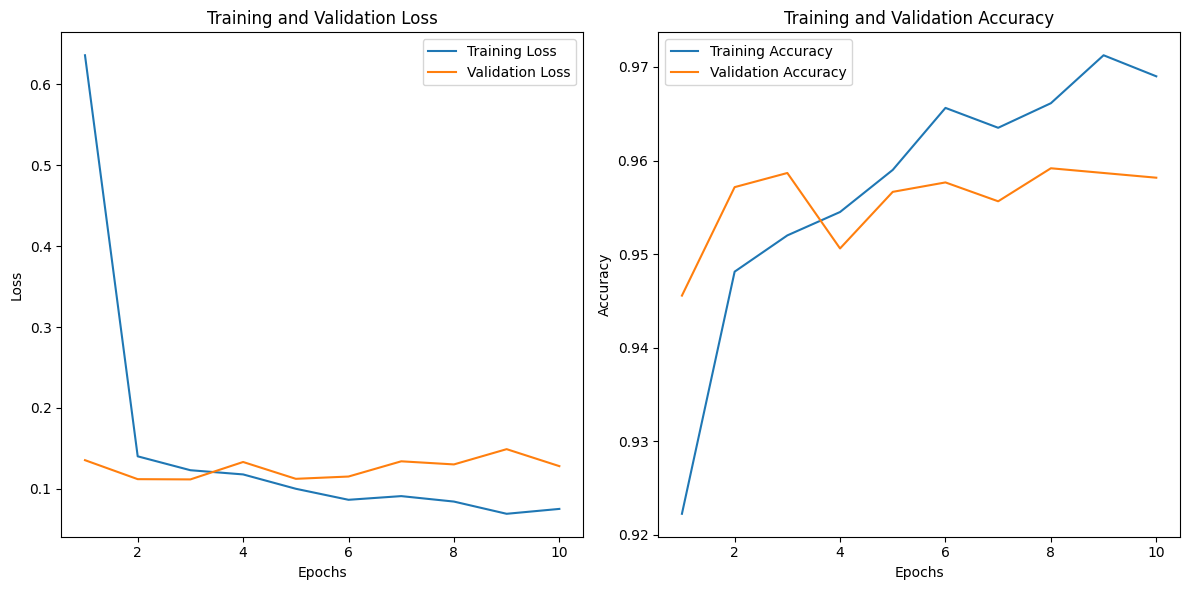

In [14]:
# Evaluate the model
eval_results = model.evaluate(val_images, val_labels)

# Print evaluation results
print("Validation Loss:", eval_results[0])
print("Validation Accuracy:", eval_results[1])

# Plot loss and accuracy
import matplotlib.pyplot as plt

# Get the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the training and validation accuracy from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Save the loss plot
plt.savefig('loss_plot_inceptionv3.png')

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# Save the accuracy plot
plt.savefig('accuracy_plot_inceptionv3.png')

# Show the plots
plt.tight_layout()
plt.show()

The things that you can see in the last epoch of the model are being fitted, which may be due to the low data in the input, the reason for increasing the training speed is that we have only used the part of the training data, or because of the small number of epoch.

In [33]:
# Save the model
model.save('/kaggle/working/my_InceptionV3.h5')

In [17]:
import matplotlib.pyplot as plt

# Training on RandomForest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Flatten the images
train_images_flat = train_images.reshape(train_images.shape[0], -1)
val_images_flat = val_images.reshape(val_images.shape[0], -1)
all_train_images_flat = all_train_images.reshape(all_train_images.shape[0], -1)

# Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(all_train_images_flat, all_train_labels)

# Make predictions on the validation set
val_predictions = clf.predict(val_images_flat)

# Calculate accuracy
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.6175


In [18]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

# Add a custom head on top of the base model
model_mobilenet = models.Sequential()

# Add the MobileNetV2 base model
model_mobilenet.add(base_model)

# Add the custom layers
model_mobilenet.add(layers.GlobalAveragePooling2D())
model_mobilenet.add(layers.Dense(256, activation='relu'))
model_mobilenet.add(layers.Dropout(0.5))
model_mobilenet.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model_mobilenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the number of training steps and validation steps per epoch
train_steps = len(train_images) // batch_size
val_steps = len(val_images) // batch_size

# Train the model
history_MobileNetV2 = model_mobilenet.fit(
    train_images,
    train_labels,
    batch_size=batch_size,
    steps_per_epoch=train_steps,
    epochs=10,
    validation_data=(val_images, val_labels),
    validation_steps=val_steps
)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
250/250 [==============================] - 12s 33ms/step - loss: 0.1727 - accuracy: 0.9341 - val_loss: 0.1144 - val_accuracy: 0.9551
Epoch 2/10
250/250 [==============================] - 6s 26ms/step - loss: 0.1259 - accuracy: 0.9524 - val_loss: 0.1113 - val_accuracy: 0.9551
Epoch 3/10
250/250 [==============================] - 6s 25ms/step - loss: 0.1009 - accuracy: 0.9629 - val_loss: 0.1085 - val_accuracy: 0.9531
Epoch 4/10
250/250 [==============================] - 6s 26ms/step - loss: 0.0910 - accuracy: 0.9657 - val_loss: 0.1040 - val_accuracy: 0.9536
Epoch 5/10
250/250 [==============================] - 6s 25ms/step - loss: 0.0816 - accuracy: 0.9701 - val_loss: 0.1038 - val_accuracy: 0.9551
Epoch 6/10
250/250 [==============================] - 6s 25ms/step - loss: 0.0768 - accuracy: 0.9726 - val_loss: 0.1254 - val_accuracy: 0.9501
Epoch 7/10
250/250 [==============================] - 6s 26ms/step - loss: 0.0

63/63 [==============================] - 2s 29ms/step - loss: 0.1187 - accuracy: 0.9565
Validation Loss: 0.11870035529136658
Validation Accuracy: 0.9564999938011169


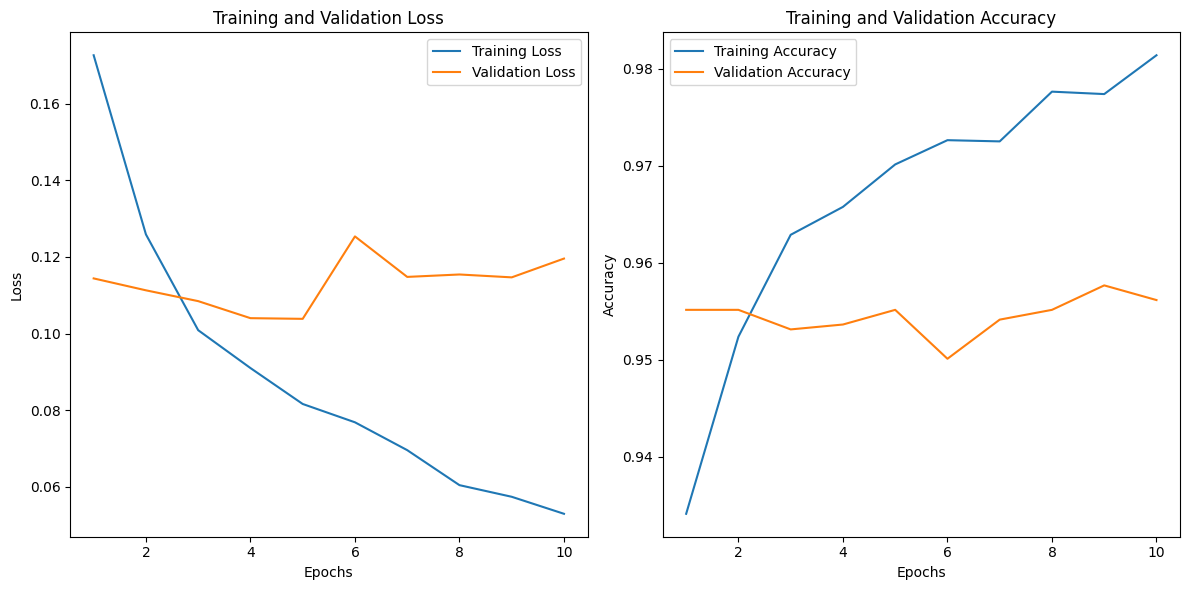

In [22]:
# Evaluate the model
eval_results = model_mobilenet.evaluate(val_images, val_labels)

# Print evaluation results
print("Validation Loss:", eval_results[0])
print("Validation Accuracy:", eval_results[1])


# Get the training and validation loss from the history object
train_loss = history_MobileNetV2.history['loss']
val_loss = history_MobileNetV2.history['val_loss']

# Get the training and validation accuracy from the history object
train_acc = history_MobileNetV2.history['accuracy']
val_acc = history_MobileNetV2.history['val_accuracy']

# Plot the loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Save the loss plot
plt.savefig('loss_plot_mobilenetv222222.png')

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# Save the loss plot
plt.savefig('accuracy_plot_mobilenetv22222.png')

# Show the plots
plt.tight_layout()
plt.show()

Training Model on MobileNetV2 has better validation accuracy rather than training on InceptionV3.(with these Hyperparameters)

In [37]:
# Save the model
model.save('/kaggle/working/my_MobileNetV2.h5')

In [21]:
from tensorflow.keras import models, layers

model_cnn = models.Sequential()

# Add the convolutional layers
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from the convolutional layers
model_cnn.add(layers.Flatten())

# Add the fully connected layers
model_cnn.add(layers.Dense(256, activation='relu'))
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the number of training steps and validation steps per epoch
train_steps = len(train_images) // batch_size
val_steps = len(val_images) // batch_size

# Train the model
history_cnn = model_cnn.fit(
    train_images,
    train_labels,
    batch_size=batch_size,
    steps_per_epoch=train_steps,
    epochs=10,
    validation_data=(val_images, val_labels),
    validation_steps=val_steps
)

Epoch 1/10
250/250 [==============================] - 12s 29ms/step - loss: 0.6748 - accuracy: 0.5855 - val_loss: 0.6103 - val_accuracy: 0.6729
Epoch 2/10
250/250 [==============================] - 6s 25ms/step - loss: 0.5940 - accuracy: 0.6864 - val_loss: 0.5984 - val_accuracy: 0.6678
Epoch 3/10
250/250 [==============================] - 6s 25ms/step - loss: 0.5305 - accuracy: 0.7330 - val_loss: 0.5709 - val_accuracy: 0.7061
Epoch 4/10
250/250 [==============================] - 6s 25ms/step - loss: 0.4602 - accuracy: 0.7834 - val_loss: 0.5047 - val_accuracy: 0.7535
Epoch 5/10
250/250 [==============================] - 6s 25ms/step - loss: 0.4066 - accuracy: 0.8158 - val_loss: 0.4816 - val_accuracy: 0.7908
Epoch 6/10
250/250 [==============================] - 6s 24ms/step - loss: 0.3359 - accuracy: 0.8531 - val_loss: 0.5494 - val_accuracy: 0.7571
Epoch 7/10
250/250 [==============================] - 6s 25ms/step - loss: 0.2650 - accuracy: 0.8875 - val_loss: 0.4797 - val_accuracy: 0.796

63/63 [==============================] - 1s 10ms/step - loss: 0.6805 - accuracy: 0.7865
Validation Loss: 0.680523157119751
Validation Accuracy: 0.7864999771118164


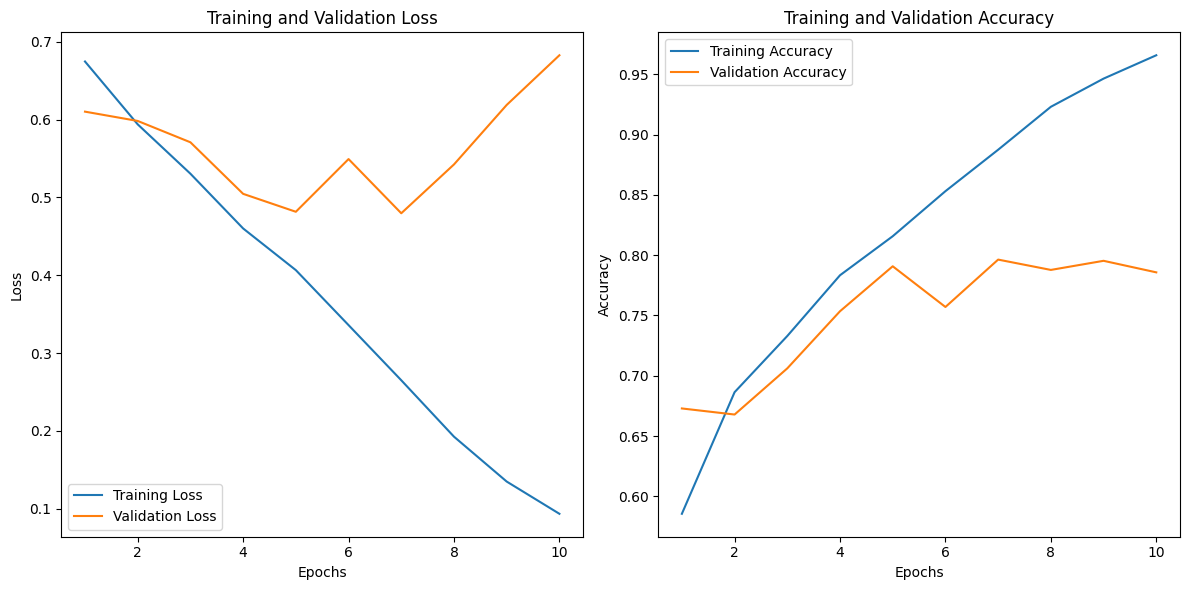

In [24]:
# Evaluate the model
eval_results = model_cnn.evaluate(val_images, val_labels)

# Print evaluation results
print("Validation Loss:", eval_results[0])
print("Validation Accuracy:", eval_results[1])

# Plot loss and accuracy
import matplotlib.pyplot as plt

# Get the training and validation loss from the history object
train_loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

# Get the training and validation accuracy from the history object
train_acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

# Plot the loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Save the loss plot
plt.savefig('loss_plot_cnn.png')

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# Save the loss plot
plt.savefig('accuracy_plot_cnn.png')

# Show the plots
plt.tight_layout()
plt.show()